# Teaching an RNN to recognize handwritten digits

The goal of this project is to create a neural net - using only my own library - and teach it to recognize handwritten digits from the MNIST dataset.

I imagine this could be done by "sliding" the RNN across the picture, a bit like convolutional neural networks, and look for spikes in the log probability of the current picture belonging to either class.

The neural net will take as input one entire column of the picture at a time. All the pictures in the MNIST dataset are 28*28 pixels, so this neural net will need 28 inputs.

In [1]:
%matplotlib inline

# Importing homemade tools
from neural_net.net import *
from testing_data.load_mnist import *
import neural_net.necessities.prepping as prepping

# Other imports
import numpy as np
import matplotlib.pyplot as plt

### Loading data
I have converted the MNIST data found at [Yann LeCun's site](http://yann.lecun.com/exdb/mnist/) into CSVs and added those files to this repo. I also removed parts of the training dataset in order to not exceed the 100MB maximum file size.

In [2]:
# Loading data
train = load_mnist('testing_data/mnist_train.csv')
test = load_mnist('testing_data/mnist_test.csv')

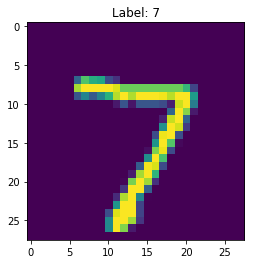

In [3]:
# Showing sample picture
plt.imshow(test[0][1])
plt.title('Label: ' + str(test[0][0]))
plt.show()

### Preparing data
As mentioned, I want to slide the RNN across columns, not rows. To make things easier down the line I'll just rotate the pictures 90 degrees right away. Sorry if the names of the functions here are a bit confusing.

In [4]:
# Function to prep a single MNIST sample
def prepSingleMNIST(sample):
     # Prepping one-hot encoded label
    label = sample[0]
    hot_label = np.zeros(10)
    hot_label[int(label)] = 1
    hot_labels = [hot_label for n in range(28)]
    # Prepping pixels
    pixels = sample[1]
    new_pixels = np.divide(np.rot90(pixels, k=-1), 255)
    # Setting target of last half of empty inputs to zero.
    l = len(new_pixels)
    for i in range(l):
        if np.sum(new_pixels[i]) == 0:
            hot_labels[i] = np.zeros(10)
    # Returning
    return new_pixels, hot_labels

# Function to prep data (want to slide rnn across columns, not rows)
def prepMNIST_single(data):
    inputs, targets = [], []
    # Looping through data
    for sample in data:
        # Prepping data
        new_pixels, hot_labels = prepSingleMNIST(sample)
        # Appending to inputs and targets
        inputs.append(new_pixels)
        targets.append(hot_labels)
    return inputs, targets

In [5]:
# Prepping data
Xtrain, Ytrain = prepMNIST_single(train)
Xtest, Ytest = prepMNIST_single(test)

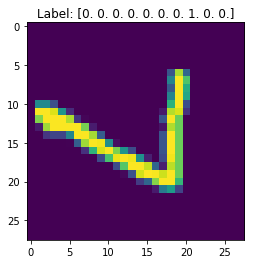

In [6]:
# Showing what data looks like now
plt.imshow(Xtest[0])
plt.title('Label: ' + str(Ytest[0][14]))
plt.show()

### Preparing batches of training data
Using batches of training samples will, in many cases, result in faster training than if you simply fit the model to one sample at a time. This function makes this part easier.

In [7]:
Xb = prepping.reBatchSeries(prepping.batchifySeries(Xtrain[:10000]), size=500)
Yb = prepping.reBatchSeries(prepping.batchifySeries(Ytrain[:10000]), size=500)

### The model
The first fun part! I've already imported the "homemade" library I'll be using, and the model is fairly easy to create. "quicklayers" makes it easy to add multiple layers (I used this function to add the hidden layers), and "add" will add a single layer to the back of the neural net. "disp" prints a short summary of the neural net's configuration.

In [8]:
# Creating model
model = neural_net(28)
model.quicklayers(layertype='recurrent', neurons=[20,20], activation='tanh')
model.add(layertype='recurrent', neurons=10, activation='sigmoid') # Model ouput. Want log probability.

# Printing model info
model.disp()



Neural net structure
 #   Type         Size   Activation   Weights
 0 | base       |   28 |            | 
 1 | recurrent  |   20 | tanh       | 980
 2 | recurrent  |   20 | tanh       | 820
 3 | recurrent  |   10 | sigmoid    | 310

Total amount of weights: 2110


### Training time!
Everything is ready! Time to fit this bad boy to our data! With 20 batches of 500 samples each, and running 500 epochs, this takes about five minutes on my macbook pro. You could probably speed this up using adaptive learning rates, fewer epochs, dropout, and different batches of data.

In [9]:
# Training
model = neural_net.load('saved_models/rnn_mnist')
model.batch_fit_sequence(Xb, Yb, epochs=500, alpha=0.025, clip=0.1)

Training |██████████████████████████████████████████████████| 100.0% MSE = 9.981046690691314e-05


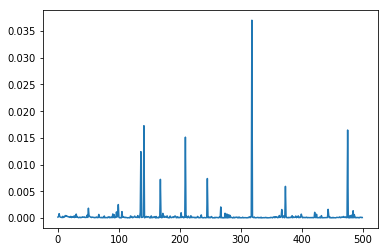

In [10]:
# Plotting MSE vs epoch
plt.plot(model.errlog)
plt.show()

As we can see from the plot: I probably didn't need to train this neural net for 500 epochs. I suggest you try to play arround with different batch sizes and training rates to improve on my results :)

### Displaying our results
Finally we get to check out how our model is performing!

Below I first declare some funtions to make life a bit easier, then I run a softmax on all outputs and plot how these change as the neural net is fed more and more data from the picture.

In [11]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def slideModel(m, pic):
    m.reset()
    preds = [m.predict(col)[0] for col in pic]
    return [softmax(pred) for pred in preds], preds

def plotPreds(preds):
    fig = plt.figure(figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(predictions)
    plt.legend([str(n) for n in range(10)])

def plotStates(states):
    fig = plt.figure(figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(np.array(states).T, aspect='auto', cmap='jet')
    plt.yticks(list(range(10)))
    plt.show()

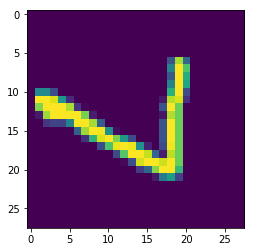

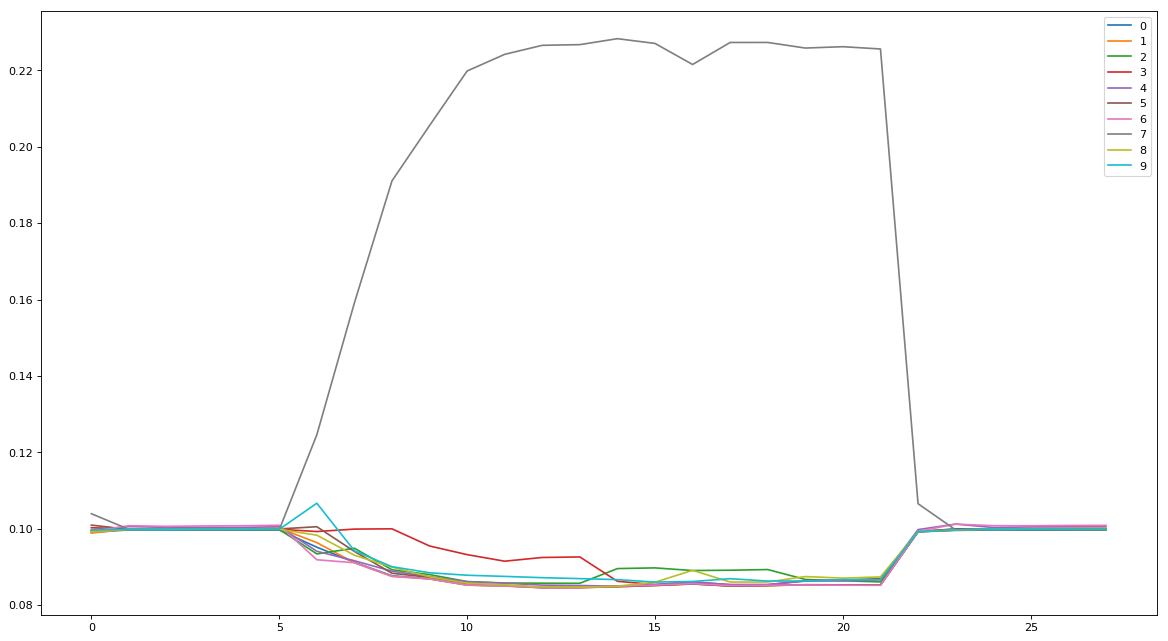

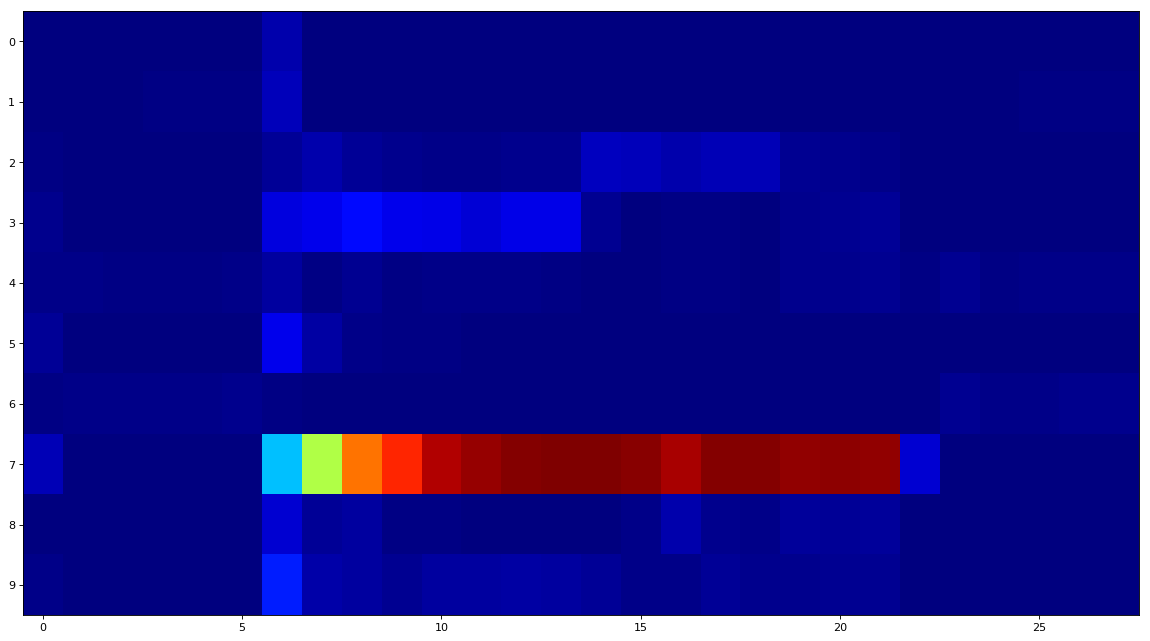

In [12]:
# Plotting prediction for some figure
predictions, states = slideModel(model, Xtest[0])

# Showing actual figure
plt.imshow(Xtest[0])
plt.show()

# Plotting predictions
plotPreds(predictions)

# Plotting output-neurons heatmap
plotStates(states)

This looks great! Let's try another one!

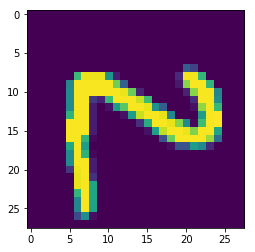

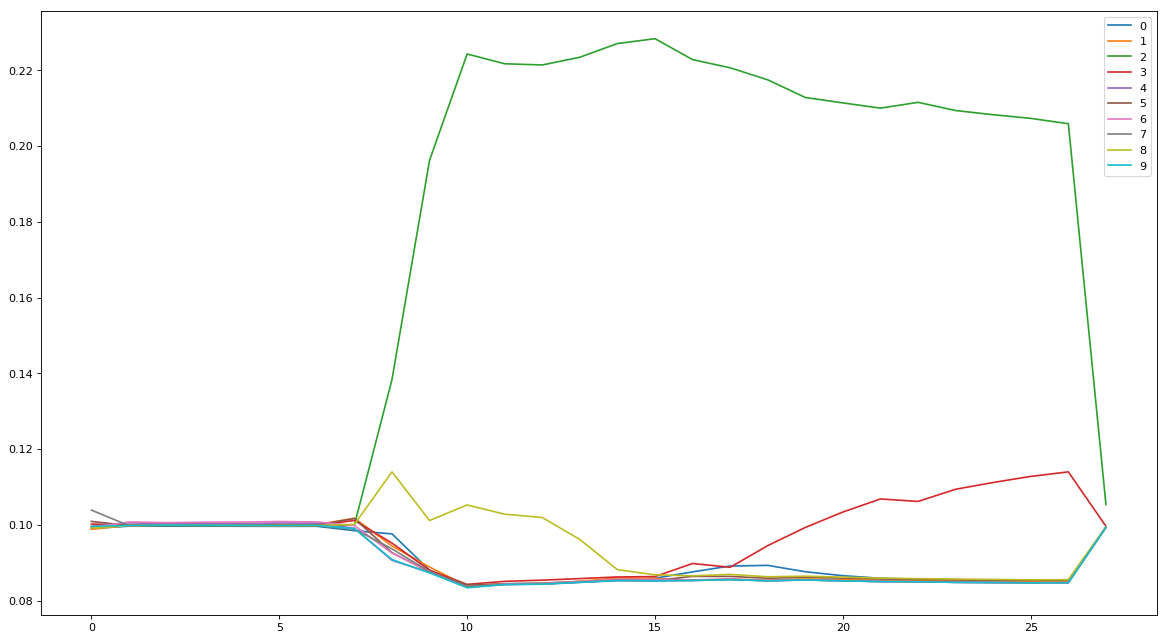

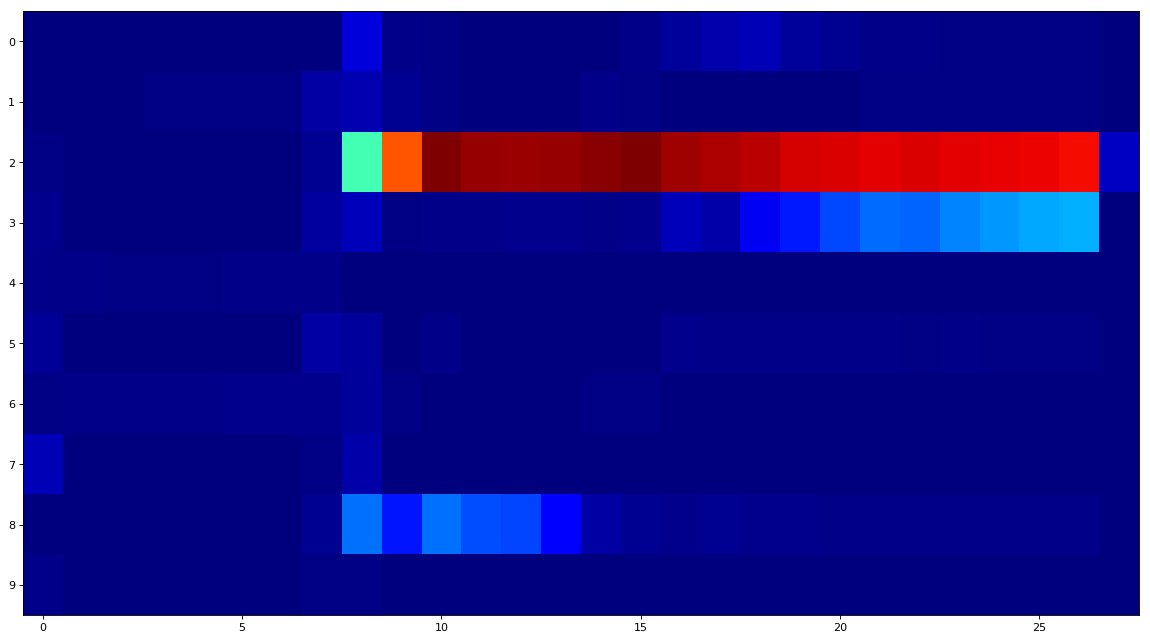

In [13]:
# Plotting prediction for some other figure
predictions, states = slideModel(model, Xtest[1])

# Showing actual figure
plt.imshow(Xtest[1])
plt.show()

# Plotting predictions
plotPreds(predictions)

# Plotting output-neurons heatmap
plotStates(states)

Cool!

As I tried to explain to a friend of mine: The reason as to why all the output neurons initially shows a value of 0.1 (or 10%) is that I compute the probability of the image showing either digit. There are 10 different digits, and the sum of all the included probabilities has to be 1.0. If the output of each neuron is 0.001, then the sum is 0.01, thus the probability of each neuron will be 0.001/0.01=0.1=10%

### Now to a more fun task
What if I make a longer image using multiple images from the dataset? I imagine the output of different neurons will spike as is slide the neural net across different digits... We'll see :)

In [14]:
# Concatenating some pictures
c_set = Xtest[:7]
bigpic = []
for sample in c_set:
    for row in sample:
        bigpic.append(row)

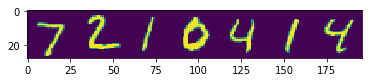

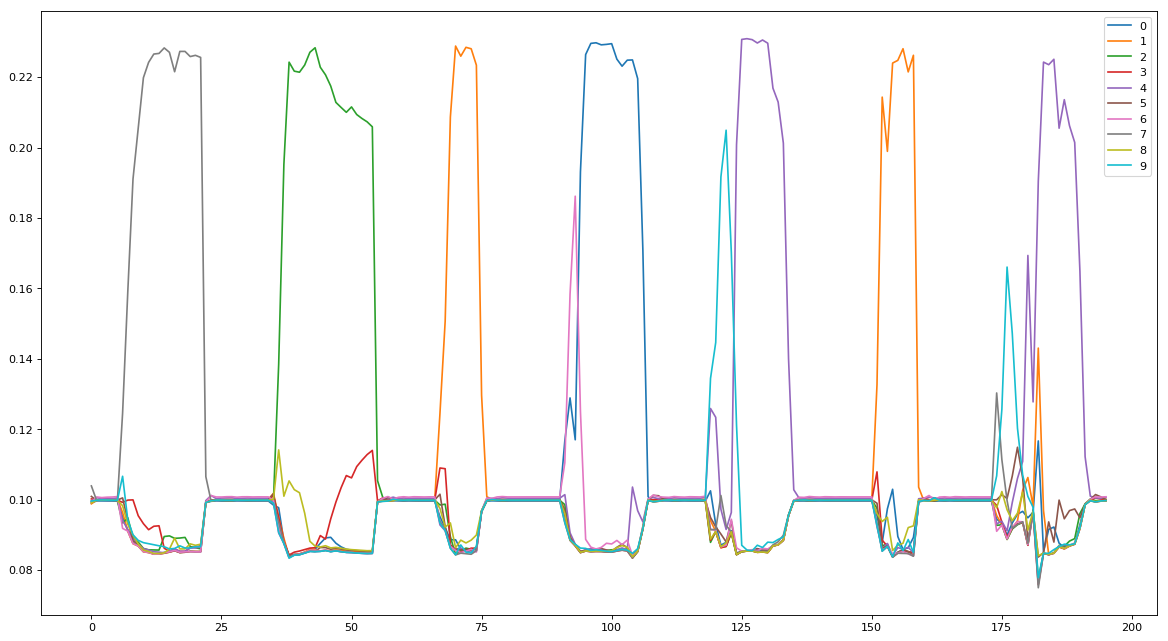

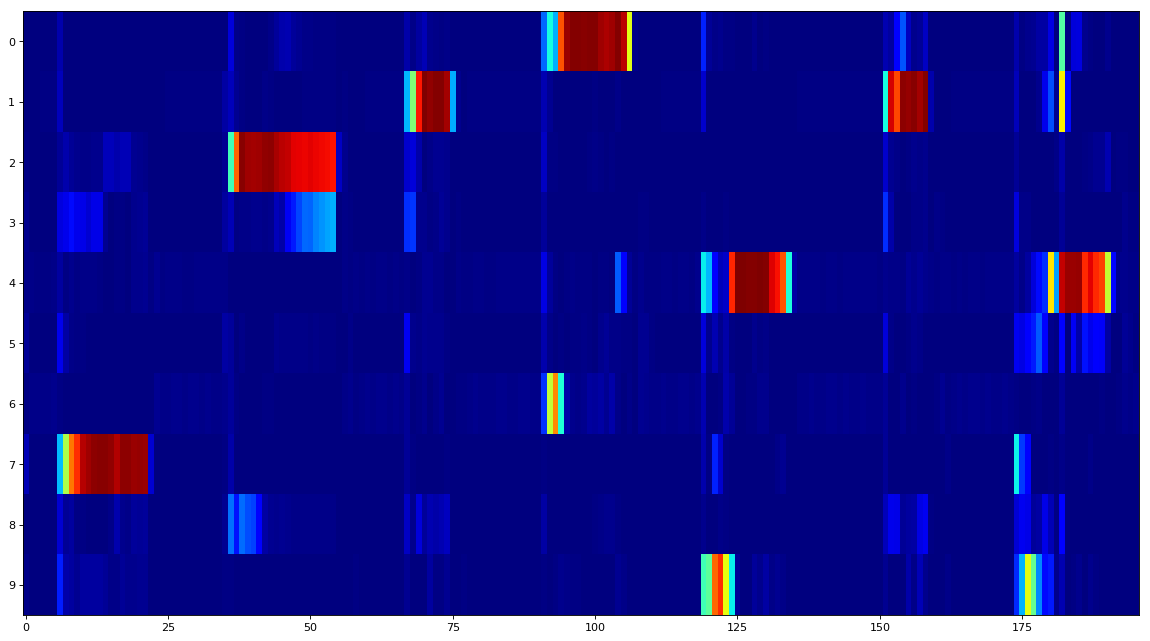

In [15]:
# Testing model on bigpic
predictions, states = slideModel(model, bigpic)

# Showing actual figure
plt.imshow(np.rot90(bigpic, k=1))
plt.show()

# Plotting predictions
plotPreds(predictions)

# Plotting output-neurons heatmap
plotStates(states)

This worked out great!

I guess our model might have performed even better if we used a mixture of pictures with single or double digits, but for now I think this result is good enough.

Thanks for reading!